# Comparison of water levels – Highway 1 vs. Railroad tracks

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import matplotlib.dates as mdates
from physoce import tseries as ts

from physoce_obs import noaatide
from data_paths import water_level_path, tide_gauge_path

## Load data

### Lower slough

In [2]:
# Load NOAA tide gauge data set
tg = noaatide.csv_to_dataframe(tide_gauge_path(),
                      pattern='*.csv')

In [3]:
lower_slough_path = os.path.join(water_level_path(),'Lower slough/')

In [4]:
def process_troll(csv_file,tg,mindepth=40):
    '''
    Load data from Rugged Troll into Pandas dataframe, and match with Monterey tide gauge.
    
    INPUTS
    csvfile - full path to csv file
    mindepth - Exclude data from below this depth as times out of water (default 40 cm)
    
    OUTPUT
    Pandas dataframe. h is the water level in Moro Cojo, hocn is the water level in Monterey Bay
    '''

    df = pd.read_csv(csv_file,skiprows=75,parse_dates=[0],
                     names=['DateTime','Seconds','Pressure_PSI','Temp_C','Depth_cm'],
                    usecols=range(5))

    goodi = df['Depth_cm'] > mindepth # trim parts out of water
    df = df.loc[goodi]
    df.set_index(df['DateTime'],inplace=True,drop=False)

    df['h'] = df['Depth_cm']/100
    
    deltat = np.diff(df.index)/np.timedelta64(1,'s') # sampling interval in seconds
    df['dhdt'] = np.gradient(df['h'].rolling(4).mean(),deltat[0]) # time derivative of water level (m/s)

    df['hocn'] = tg['Water Level']
    df['hocn'] = df['hocn'].interpolate(limit=int(np.round(3600/deltat[0])))

    return df

In [5]:
ds = dict()

csv_file = os.path.join(lower_slough_path,'Moro Cojo Fall 2015_2015-12-14_13-49-50-340.csv')
ds['Fall_2015'] = process_troll(csv_file,tg)

csv_file = os.path.join(lower_slough_path,'Spring 2016 - Moro Cojo_2016-05-31_14-59-30-328.csv')
ds['Spring_2016'] = process_troll(csv_file,tg)

In [6]:
csv_file = os.path.join(lower_slough_path,'2017-2018_2018-01-23_16-04-48-936.csv')
ds['Fall_2017'] = process_troll(csv_file,tg,mindepth=8)

ii = (ds['Fall_2017'].index > np.datetime64('2017-10-25')) & (ds['Fall_2017'].index <= np.datetime64('2018-01-22'))
ds['Fall_2017'] = ds['Fall_2017'].loc[ii]

### Railroad tracks

In [7]:
xls_dir = 'Data/RailroadTrack_Elevation/'
xls_filename = '15-064_Water Level Data_Moro Cojo Slough at RR Tracks_for CCWG_10-15-18.xlsx'

In [8]:
xls_path = os.path.join(xls_dir,xls_filename)

In [9]:
sheets_list = ['15-064_ 2-1-17 to 7-23-17',
              '10-23-17 to 1-10-18',
              '1-10-18 to 3-13-18']

In [10]:
df1 = pd.read_excel(xls_path,sheets_list[0],
                    header=69,
                    usecols='A:E,H,J,O')
df1 = df1.rename(columns={'Unnamed: 7': 'Elevation NAVD (feet)'})

df1 = df1.loc[df1['Date and Time'] >= np.datetime64('2017-02-01 13:00')]

In [11]:
df2 = pd.read_excel(xls_path,sheets_list[1],
                    header=71,
                    usecols='A:E,H:J')
df2 = df2.rename(columns={'Unnamed: 7': 'Elevation NAVD (feet)'})
df2 = df2.loc[(df2['Date and Time'] >= np.datetime64('2017-10-24 15:00'))
            & (df2['Date and Time'] <= np.datetime64('2018-01-10 10:00'))]

In [12]:
df3 = pd.read_excel(xls_path,sheets_list[2],
                    header=144,
                    usecols='A:E,I,K,M')
df3 = df3.rename(columns={'Unnamed: 5': 'Depth (Inches)',
                    'Unnamed: 6': 'Depth (feet)',
                    'Unnamed: 7': 'Elevation NAVD (feet)'})
df3 = df3.loc[(df3['Date and Time'] >= np.datetime64('2018-01-10 13:00'))
            & (df3['Date and Time'] <= np.datetime64('2018-03-12 10:00'))]

In [13]:
df = pd.concat([df2,df3],sort=True)
df = df.set_index('Date and Time')
df = df.loc[(df.index >= ds['Fall_2017'].index[0])
            & (df.index <= ds['Fall_2017'].index[-1])]

### Plots - railroad tracks

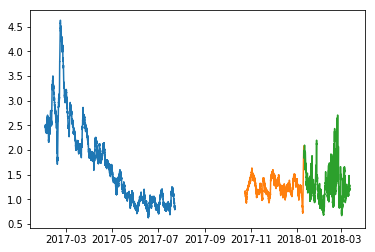

In [14]:
plt.figure()
plt.plot(df1['Date and Time'],df1['Elevation NAVD (feet)'])
plt.plot(df2['Date and Time'],df2['Elevation NAVD (feet)'])
plt.plot(df3['Date and Time'],df3['Elevation NAVD (feet)'])

### Lower slough

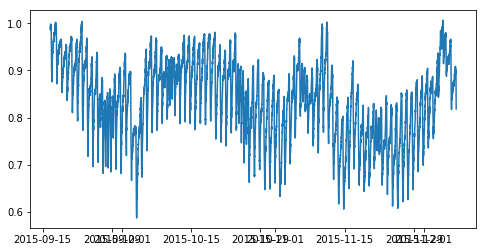

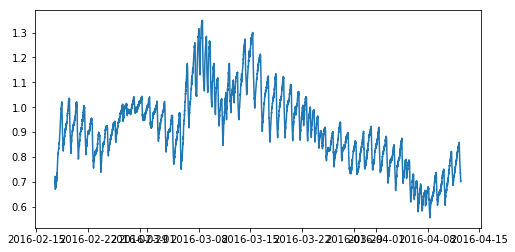

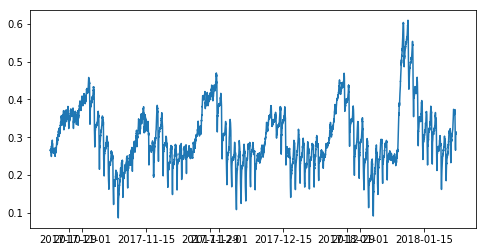

In [15]:
all_per = ['Fall_2015','Spring_2016','Fall_2017']

for per in all_per:
    dsp = ds[per]
    
    plt.figure(figsize=[8,4])
    plt.plot(dsp.index,dsp['h'],'-')

### Combined - railroad tracks, lower slough, Monterey Bay

Data at the Railroad tracks (from Shawn Ryan) were compared with data from the lower slough near Highway 1. There is overlap of data during late 2017 – early 2018.

/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/scipy/signal/signaltools.py:251: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  in1zpadded[sc] = in1.copy()


Text(0, 0.5, 'water level [m]')

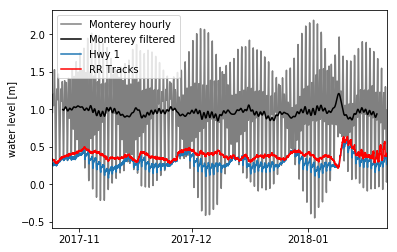

In [16]:
per = 'Fall_2017'

plt.figure(figsize=[6,4])
plt.plot(ds[per].index,ds[per]['hocn'],'-',color='gray')
plt.plot(ds[per].index,ts.pl66(ds[per]['hocn'],dt=1/4),'-',color='k')
plt.plot(ds[per].index,ds[per]['h'],'-')
plt.plot(df.index,df['Elevation NAVD (feet)']*0.3048,'r-')
plt.xlim([ds[per].index[0],ds[per].index[-1]])
plt.xticks(['2017-11','2017-12','2018-01'])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.legend(['Monterey hourly','Monterey filtered','Hwy 1','RR Tracks'],loc='upper left')
plt.ylabel('water level [m]')

#plt.gca().minorticks_off()
#plt.xticks(rotation=30)


Text(0, 0.5, 'water level [m]')

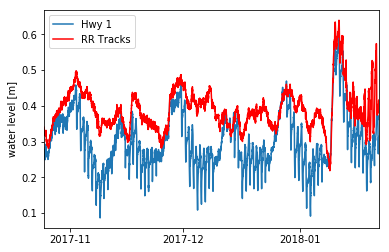

In [17]:
plt.figure(figsize=[6,4])
plt.plot(ds[per].index,ds[per]['h'],'-')
#plt.plot(ds[per].index,ds[per]['hocn'],'-',color='gray')
plt.plot(df.index,df['Elevation NAVD (feet)']*0.3048,'r-')
plt.xlim([ds[per].index[0],ds[per].index[-1]])
plt.xticks(['2017-11','2017-12','2018-01'])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.legend(['Hwy 1','RR Tracks'],loc='upper left')
plt.ylabel('water level [m]')


Comparing these data sets, the water level at Highway 1 is typically lower than the Railroad tracks during spring tides, when the lower low tides cause water to flow out of the slough. During neap tides, after there has been inflow into the slough, the water levels at the two sites tend to equilibrate.

Low-pass filtering the Monterey Bay water levels (to remove tidal fluctuations) shows that there is an event when high water levels in Monterey Bay coincide with a neap tide. This is associated with the highest water levels at both sites during this time period.

In [18]:
ds[per] = ds[per].loc[~ds[per].index.duplicated()]
df = df.loc[~df.index.duplicated()]
df['h'] = ds[per]['h']

Text(0, 0.5, 'RR Tracks water level [m] - NAVD')

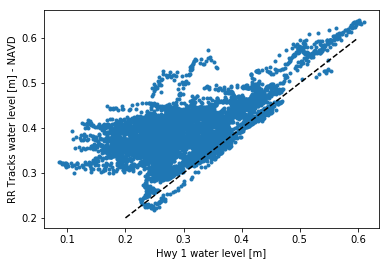

In [19]:
plt.figure()
plt.plot(df['h'],df['Elevation NAVD (feet)']*0.3048,'.')
plt.plot([0.2,0.6],[0.2,0.6],'k--')
plt.xlabel('Hwy 1 water level [m]')
plt.ylabel('RR Tracks water level [m] - NAVD')